## 作者自己训练的模型，并且制作了一个网站

网站地址：http://stratospark.com/demos/food-101/

可以导入模型，但是我不会使用

接下来我们基于tensorflow2 来重写作者的代码，训练模型

## 1 下载数据集

数据集用到的是101类别的食物，网址为：http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

下载后解压到项目路径

# 2 查看数据

### 2.1 导入相关模块

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os

### 2.2查看图片

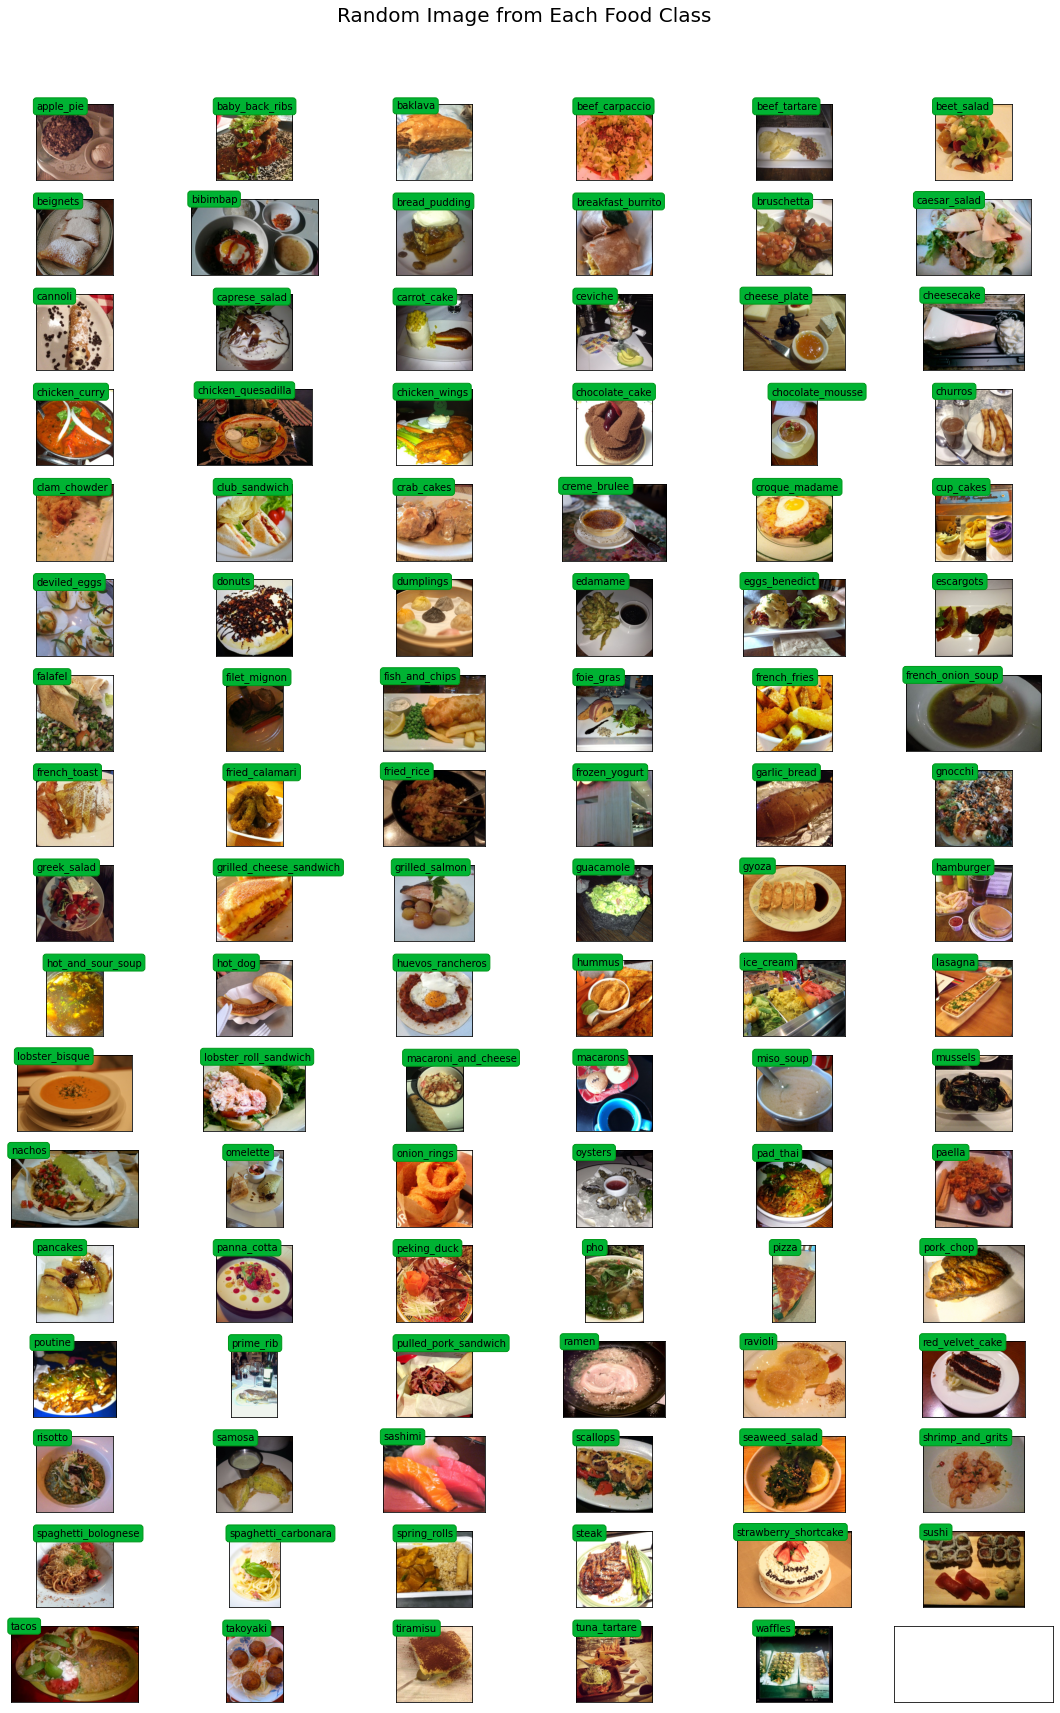

In [2]:
root_dir = 'food-101/images/'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### 2.3查看数据文件夹树

In [8]:
import os
import os.path

def dfs_showdir(path, depth):
    if depth == 0:
        print("root:[" + path + "]")

    for item in os.listdir(path):
        if '.git' not in item:
            print("|      " * depth + "+--" + item)

            newitem = path +'/'+ item
#             if os.path.isdir(newitem):
#                 dfs_showdir(newitem, depth +1)

food-101文件夹下：
- images是存放原数据的文件夹
- meta中为文本文件，指明了训练数据测试数据的划分
- train、test为后续生成的用于存放训练数据和测试数据的文件夹

In [9]:
dfs_showdir('./food-101',0)

root:[./food-101]
+--images
+--license_agreement.txt
+--meta
+--README.txt
+--test
+--train


## 3 将image中的数据划分为训练数据和测试数据

In [10]:
import collections
import shutil
from collections import defaultdict

### 3.1 将测试数据集从image中提取出来

In [12]:
img_paths = './food-101/images'
test_path = './food-101/test'
if not os.path.isdir(test_path):
    os.mkdir(test_path)
    
    with open('./food-101/meta/test.txt','r') as testf:  # 从meta文件夹下读取图像测试数据
        for line in testf.readlines():
            dir_name, id = line.strip().split('/') # 把文件夹和图片id分别提取出来
            img = id + '.jpg'
            src_imgp = os.path.join(img_paths,dir_name,img)  # 源文件地址
            dst_imgp = os.path.join(test_path,dir_name)  # 要导入的地方
            if not os.path.isdir(dst_imgp):  # 不存在文件夹则创建
                os.mkdir(dst_imgp)
            shutil.copy2(src_imgp, dst_imgp)
else:
    print('测试数据文件夹已存在')

测试数据文件夹已存在


### 3.2 将训练数据集从image中提取出来

In [11]:
img_paths = './food-101/images'
train_path = './food-101/train'
if not os.path.isdir(train_path):
    os.mkdir(train_path)
    
    with open('./food-101/meta/train.txt','r') as trainf:  # 从meta文件夹下读取图像测试数据
        for line in trainf.readlines():
            dir_name, id = line.strip().split('/') # 把文件夹和图片id分别提取出来
            img = id + '.jpg'
            src_imgp = os.path.join(img_paths,dir_name,img)  # 源文件地址
            dst_imgp = os.path.join(train_path,dir_name)  # 要导入的地方
            if not os.path.isdir(dst_imgp):  # 不存在文件夹则创建
                os.mkdir(dst_imgp)
            shutil.copy2(src_imgp, dst_imgp)
else:
    print('训练数据文件夹已存在')

训练数据文件夹已存在


### 3.3 删除一部分数据

这里是为了使用tensorflow2把代码复现，目的在于跑通，不在于达到很高的精确度，所以删除大部分数据

数据大于15张就删除90%

In [13]:
import random

def thanos(dir):
    files = os.listdir(dir)
    sample = random.sample(files, int(len(files)*0.9))
    for each in sample:
        file_path = os.path.join(dir, each)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except PermissionError as e:
            pass


print('清理90%的图片数据')
if len(os.listdir('./food-101/train/apple_pie')) >= 15:
    img_dirs = ['./food-101/test', './food-101/train']
    for img_dir in img_dirs:
        list_test_path = os.listdir(img_dir)
        for fin_path in list_test_path:
            fin_dir = os.path.join(img_dir, fin_path )
            thanos(fin_dir)
else:
    print('已经清理过了')

清理90%的图片数据
已经清理过了


### 4 对数据进行预处理

这里作者使用inceptionv3模型来进行图片预测，需要对图片进行预处理，使其满足模型输入的图片格式

### 4.1 定义一个图像处理的函数，用来改变图像的size并归一化

In [21]:
import tensorflow as tf
import pathlib  # 和os.path的功能类似，os.path返回一个字符串路径，pathlib返回一个对象

def load_and_preprocess_image(img_path):
    # read pictures
    img_raw = tf.io.read_file(img_path)
    # decode pictures
    img_tensor = tf.image.decode_jpeg(img_raw, channels=channels)  # 读取图片并将图片解码为tensor向量
    # resize
    img_tensor = tf.image.resize(img_tensor, [image_height, image_width]) # 改变大小 
    img_tensor = tf.cast(img_tensor, tf.float32) 
    # normalizaion
    img = img_tensor / 255.0  # 归一化
    return img

### 4.2 定义一个获取img地址和label 的函数

In [22]:
def get_images_and_labels(data_root_dir):
    # get all images' paths (format: string)
    data_root = pathlib.Path(data_root_dir)
    all_image_path = [str(path) for path in list(data_root.glob('*/*'))]  # glob('*/*') 指的是将目录下的所有子目录文件路径列出来
    # get labels' names
    label_names = sorted(item.name for item in data_root.glob('*/')) # glob('*/*') 指的是该目录文件下的所有文件路径列出来
    # 每一个label给上对应的标签0-100，并生成字典
    label_to_index = dict((index, label) for label, index in enumerate(label_names))  
    # 给每张图片对应数字标签
    all_image_label = [label_to_index[pathlib.Path(single_image_path).parent.name] for single_image_path in all_image_path]  

    return all_image_path, all_image_label

### 4.3定义一个设置图片数据集以及标签数据集

这里用到了`tf.data.Dataset`这个方法，还挺好用的

In [23]:
def get_dataset(dataset_root_dir):
    all_image_path, all_image_label = get_images_and_labels(data_root_dir=dataset_root_dir)
    # print("image_path: {}".format(all_image_path[:]))
    # print("image_label: {}".format(all_image_label[:]))
    # load the dataset and preprocess images
    image_dataset = tf.data.Dataset.from_tensor_slices(all_image_path).map(load_and_preprocess_image) # 这里直接把数据转为dataset速度会快很多
    label_dataset = tf.data.Dataset.from_tensor_slices(all_image_label)
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    image_count = len(all_image_path)

    return dataset, image_count

### 4.4定义用于生成训练的数据集的函数

In [24]:
def generate_datasets(img_dir, batch_size):
    dataset, count = get_dataset(dataset_root_dir=img_dir)
    # read the original_dataset in the form of batch
    # tf.Dataset.shuffle 用于打乱数据集，buffer_size 会指定同时写入内存中进行打乱的数据量
    # 在这里设置batch_size的值能够把dataset中的元素按照batch拆分
    dataset = dataset.shuffle(buffer_size=count).batch(batch_size=8).repeat()
    return dataset, count

## 5 开始模型训练

### 5.1 设置超参数

In [25]:
EPOCHS = 3
BATCH_SIZE = 8
NUM_CLASSES = 101
image_height = 299
image_width = 299
train_dir = './food-101/train/'
test_dir = './food-101/test/'

### 5.2 获取训练集和测试集的dataset

In [27]:
%%time
train_dataset, train_count = generate_datasets(img_dir=train_dir, batch_size=BATCH_SIZE)
test_dataset, test_count = generate_datasets(img_dir=test_dir, batch_size=BATCH_SIZE)

Wall time: 33.9 ms


In [28]:
print(train_count)
print(train_dataset)

303
<RepeatDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>


### 5.3 导入预训练模型

使用tensorflow官方提供的inceptionv3预训练模型作为基础模型，并进行模型适当改造

#### 5.3.1导入必要的包和模块

In [29]:
from tensorflow import keras

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau

#### 5.3.2 从新搭建并编译模型

In [30]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
model = Sequential([
    base_model,
    AveragePooling2D(pool_size=(8, 8)),
    Dropout(.4),
    Flatten(),
    Dense(NUM_CLASSES, activation='softmax')
])


opt = SGD(lr=.01, momentum=.9)
model.compile(optimizer=opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
average_pooling2d_9 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               206949    
Total params: 22,009,733
Trainable params: 21,975,301
Non-trainable params: 34,432
_________________________________________________________________


### 5.4 开始模型训练

In [32]:
model.fit_generator(train_dataset,
                    steps_per_epoch=train_count//BATCH_SIZE,
                    epochs=2,
                    verbose=1,
                    )

E:\anaconda\anaconda\envs\tensorflow24\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
37/37 [==============================] - 76s 2s/step - loss: 4.8808 - accuracy: 0.0090
Epoch 2/2
37/37 [==============================] - 70s 2s/step - loss: 4.7546 - accuracy: 0.0126


至此，模型就已经训练完成

## 6 总结

总的来说，模型构建和训练的地方代码并没有特别大的改动，因为tf1和tf2都是用keras写的。

主要是在数据处理的地方，改为了dataset方式。